In [780]:
# Cleaning and data manipulation
import pandas as pd
import numpy as np
import datetime

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

# Statistic test
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, spearmanr, mannwhitneyu, kruskal

# Other libraries
import warnings
warnings.filterwarnings("ignore")

In [781]:
airbnb=pd.read_csv('airbnb_cleaned.csv')
airbnb["last_review"] = pd.to_datetime(airbnb["last_review"], errors="coerce")
airbnb.head()

,id,name,host_id,host_name,neighbourhood,room_type,latitude,longitude,price,minimum_nights,availability_365,calculated_host_listings_count,number_of_reviews,number_of_reviews_ltm,reviews_per_month,last_review,host_response_rate,review_scores_rating,area_category
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,Entire home/apt,13.75983,100.54134,1905,3,353,2,65,0,0.50,2020-01-06,100.0,4.86,Inner City
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,Private room,13.66818,100.61674,1316,1,358,2,0,0,0.00,1970-01-01,100.0,NaN,Middle City
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,Private room,13.75232,100.62402,800,60,365,1,0,0,0.00,1970-01-01,100.0,NaN,Middle City
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,Private room,13.78823,100.57256,1286,7,323,1,2,1,0.03,2022-04-01,100.0,4.83,Inner City
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,Private room,13.76872,100.63338,1905,1,365,3,0,0,0.00,1970-01-01,100.0,4.00,Middle City


### **1. Perbedaan Rating Antar Wilayah**

Penelitian ini bertujuan menganalisis bagaimana karakteristik properti Airbnb dan performa host dapat menjelaskan perbedaan rating antar wilayah di Bangkok.

Melihat distribusi per `area_category` untuk menentukan menggunakan mean atau median.

In [784]:
# Menguji normalitas untuk masing-masing area_category
area_categories = airbnb['area_category'].unique()

for area in area_categories:
    data = airbnb[airbnb['area_category'] == area]['review_scores_rating'].dropna()
    
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test for {area} - p-value: {p_value}")
    if p_value > 0.05:
        print(f"Distribusi di {area} mendekati normal (p > 0.05)")
    else:
        print(f"Distribusi di {area} tidak normal (p <= 0.05)")

Shapiro-Wilk Test for Inner City - p-value: 1.0150768468522073e-78
Distribusi di Inner City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Middle City - p-value: 3.170917669069305e-46
Distribusi di Middle City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Outer City - p-value: 2.2197949886973047e-15
Distribusi di Outer City tidak normal (p <= 0.05)


Karena ketiga unique pada kolom `area_category` terhadap ulasan tidak terdistribusi normal, maka kita akan menggunakan median sebagai acuan.

In [786]:
# Median ulasan per neighbourhood
med_rating_neighbourhood = round(airbnb.groupby('neighbourhood')['review_scores_rating'].median().reset_index().sort_values(by='review_scores_rating', ascending=False),2)

# Median ulasan per area_category
med_rating_area = round(airbnb.groupby('area_category')['review_scores_rating'].median().reset_index().sort_values(by='review_scores_rating', ascending=False),2)

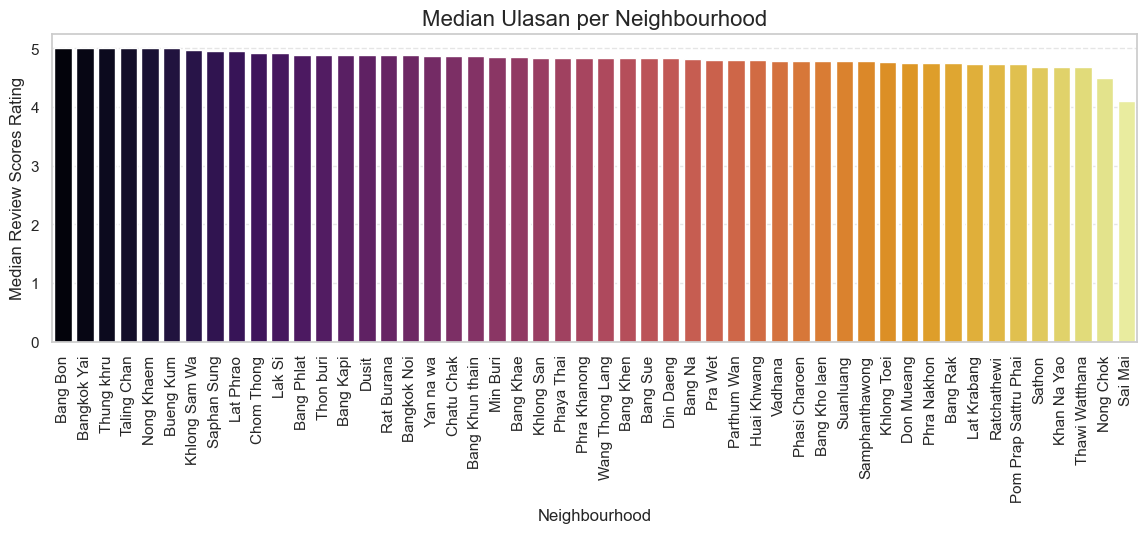

In [787]:
plt.figure(figsize=(14, 4))
sns.barplot(data=med_rating_neighbourhood, x='neighbourhood', y='review_scores_rating', palette='inferno')
plt.title('Median Ulasan per Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood')
plt.ylabel('Median Review Scores Rating')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [939]:
print(med_rating_neighbourhood.head())

   neighbourhood  review_scores_rating
0       Bang Bon                   5.0
11   Bangkok Yai                   5.0
46    Thung khru                   5.0
43   Taling Chan                   5.0
28    Nong Khaem                   5.0


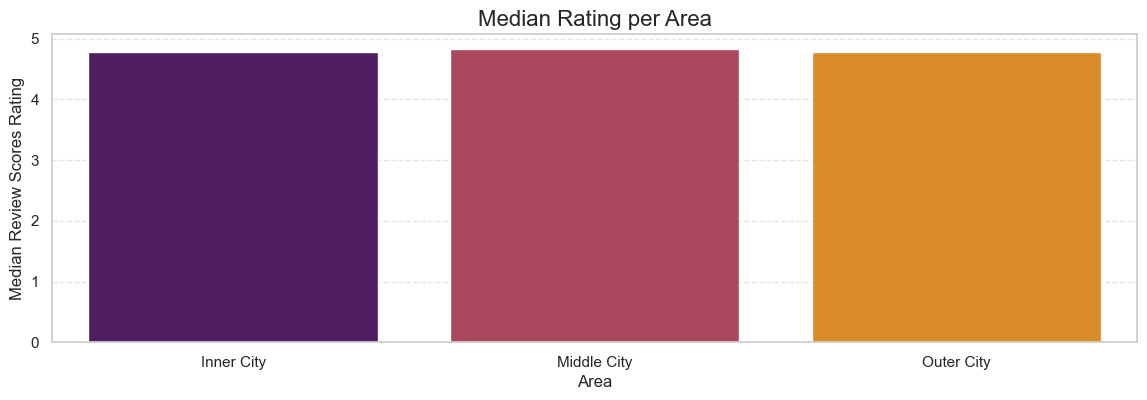

In [789]:
plt.figure(figsize=(14, 4))
sns.barplot(data=med_rating_area, x='area_category', y='review_scores_rating', palette='inferno', order=['Inner City', 'Middle City', 'Outer City'])
plt.title('Median Rating per Area', fontsize=16)
plt.xlabel('Area')
plt.ylabel('Median Review Scores Rating')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [790]:
med_rating_area

,area_category,review_scores_rating
1,Middle City,4.83
0,Inner City,4.78
2,Outer City,4.78


Menguji apakah ada perbedaan signifikan antara nilai ulasan/rating pada wilayah Inner City, Middle City, dan Outer City menggunakan Kruskal Wallis. 

In [792]:
inner_ratings = airbnb[airbnb['area_category'] == 'Inner City']['review_scores_rating'].dropna()
middle_ratings = airbnb[airbnb['area_category'] == 'Middle City']['review_scores_rating'].dropna()
outer_ratings = airbnb[airbnb['area_category'] == 'Outer City']['review_scores_rating'].dropna()

# Uji Kruskal-Wallis
stat, p_value = kruskal(inner_ratings, middle_ratings, outer_ratings)

print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Ada perbedaan signifikan antara median ulasan untuk Inner City, Middle City, dan Outer City Area (p < 0.05).")
else:
    print("Tidak ada perbedaan signifikan antara median ulasan untuk Inner City, Middle City, dan Outer City Area (p >= 0.05).")

p-value: 1.2387910660521083e-05
Ada perbedaan signifikan antara median ulasan untuk Inner City, Middle City, dan Outer City Area (p < 0.05).


In [793]:
# Uji Mann-Whitney
stat, p_value = mannwhitneyu(middle_ratings, outer_ratings)

print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Tolak hipotesis nol: Ada perbedaan signifikan median rating antara Middle City dan Outer City.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada perbedaan signifikan median rating antara Middle City dan Outer City.")


P-value: 0.16163819305871485
Gagal menolak hipotesis nol: Tidak ada perbedaan signifikan median rating antara Middle City dan Outer City.


**Interpretasi:**

**Inner City, Middle City, dan Outer City**
- p-value = 1.24e-05: Nilai p-value yang sangat kecil (jauh lebih kecil dari 0.05) menunjukkan bahwa ada perbedaan yang sangat signifikan secara statistik antara median review_scores_rating untuk ketiga kategori area (Inner City, Middle City, dan Outer City). Dengan kata lain, kita dapat menolak hipotesis nol yang menyatakan bahwa tidak ada perbedaan signifikan antara median rating di ketiga area.

**Middle City, dan Outer City**
- p-value = 0.1616: Nilai p-value ini lebih besar dari 0.05, yang menunjukkan bahwa tidak ada bukti yang cukup untuk menolak hipotesis nol. Hipotesis nol menyatakan bahwa tidak ada perbedaan yang signifikan antara median rating ulasan di Middle City dan Outer City. Karena p-value lebih besar dari 0.05, kita gagal menolak hipotesis nol, yang berarti bahwa perbedaan median antara kedua area tersebut tidak signifikan secara statistik.

**Insight:**

- Berdasarkan hasil ini, bisa disimpulkan bahwa adanya perbedaan ulasan yang signifikan Inner City terhadap (Middle City dan Outer City).
- Tetapi, tidak ada perbedaan signifikan antara ulasan dari Middle City dan Outer City.
- Artinya, Inner City menjadi wilayah dengan ulasan tertinggi.

**Pertanyaan untuk Analisis Lebih Lanjut:**

Apa faktor-faktor yang menyebabkan Inner City memiliki nilai tertinggi dibanding wilayah lainnya? (misalnya, jenis properti yang dominan, harga, atau layanan listing)

In [795]:
# Distribusi room_type per neighbourhood
room_type_dist_neighbourhood = airbnb.groupby(['neighbourhood', 'room_type']).size().unstack(fill_value=0)

# Distribusi room_type per area_category
room_type_dist_area = airbnb.groupby(['area_category', 'room_type']).size().unstack(fill_value=0)

print(room_type_dist_neighbourhood.head())

room_type      Entire home/apt  Hotel room  Private room  Shared room
neighbourhood                                                        
Bang Bon                     2           0             3            0
Bang Kapi                  124           1           132            3
Bang Khae                   35           1            56            0
Bang Khen                   48           3            64            1
Bang Kho laen               93           2            45            0


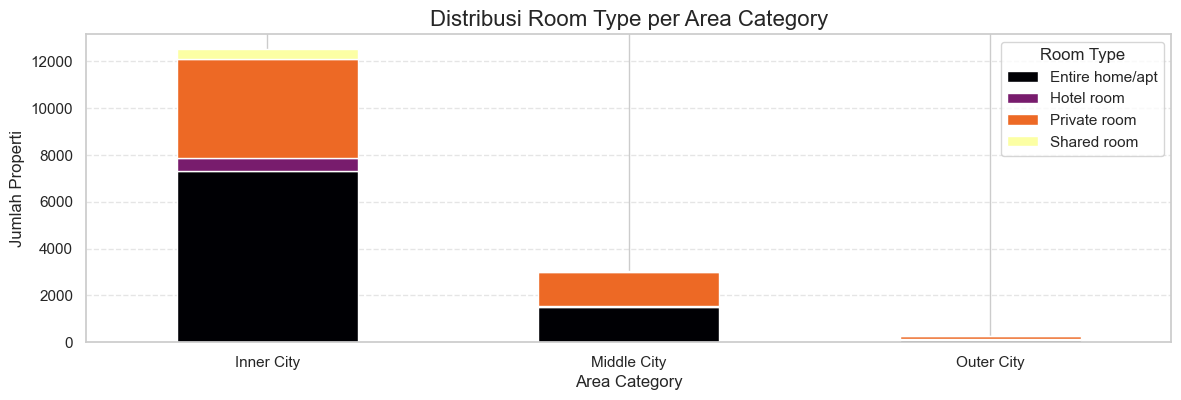

In [796]:
room_type_dist_area.plot(kind='bar', stacked=True, figsize=(14, 4), colormap='inferno')
plt.title('Distribusi Room Type per Area Category', fontsize=16)
plt.xlabel('Area Category')
plt.ylabel('Jumlah Properti')
plt.legend(title='Room Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [797]:
room_type_dist_area

room_type,Entire home/apt,Hotel room,Private room,Shared room
area_category,,,,
Inner City,7301,586,4187,454
Middle City,1509,48,1435,50
Outer City,102,14,148,19


Menguji apakah distribusi frekuensi jenis kamar di Inner City, Middle City, dan Outer City berbeda antara satu sama lain dengan menggunakan Chi-Square.

In [799]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(room_type_dist_area)

print(f"P-value: {p_val}")

if p_val < 0.05:
    print("Tolak hipotesis nol: Ada perbedaan signifikan dalam distribusi jenis kamar antar area.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada perbedaan signifikan dalam distribusi jenis kamar antar area.")

P-value: 2.0644034426712967e-61
Tolak hipotesis nol: Ada perbedaan signifikan dalam distribusi jenis kamar antar area.


**Interpretasi:**

- P-value yang lebih kecil dari 0.05 menunjukkan bahwa kita dapat menolak hipotesis nol. Artinya, ada perbedaan signifikan dalam distribusi jenis kamar antar area (Inner City, Middle City, Outer City).


**Insight:**

- Berdasarkan hasil ini, bisa disimpulkan bahwa perbedaan distribusi jenis kamar yang signifikan mempengaruhi ulasan terhadap Inner City.

**Pertanyaan untuk Analisis Lebih Lanjut:**

Apa ada faktor lain yang menyebabkan Inner City memiliki nilai tertinggi dibanding wilayah lainnya?

Melihat distribusi per area_category untuk menentukan menggunakan mean atau median.

In [802]:
# Menguji normalitas untuk masing-masing area_category
area_categories = airbnb['area_category'].unique()

for area in area_categories:
    data = airbnb[airbnb['area_category'] == area]['price']
    
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test for {area} - p-value: {p_value}")
    if p_value > 0.05:
        print(f"Distribusi di {area} mendekati normal (p > 0.05)")
    else:
        print(f"Distribusi di {area} tidak normal (p <= 0.05)")

Shapiro-Wilk Test for Inner City - p-value: 1.4514052575787555e-120
Distribusi di Inner City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Middle City - p-value: 3.9711650861408286e-81
Distribusi di Middle City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Outer City - p-value: 1.4472199681645422e-27
Distribusi di Outer City tidak normal (p <= 0.05)


Karena ketiga unique pada kolom `area_category` terhadap price tidak terdistribusi normal, maka kita akan menggunakan median sebagai acuan.

In [804]:
# Median harga per neighbourhood
price_nights_neighbourhood = round(airbnb.groupby('neighbourhood')['price'].median().reset_index())

# Median harga per area_category
price_nights_area = round(airbnb.groupby('area_category')['price'].median().reset_index())

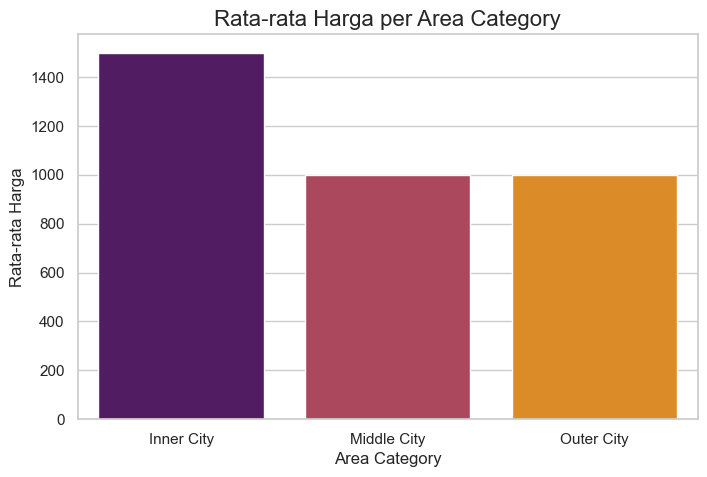

In [805]:
plt.figure(figsize=(8, 5))
sns.barplot(data=price_nights_area, x='area_category', y='price', palette='inferno')
plt.title('Rata-rata Harga per Area Category', fontsize=16)
plt.xlabel('Area Category')
plt.ylabel('Rata-rata Harga')
plt.show()

In [806]:
price_nights_area

,area_category,price
0,Inner City,1500.0
1,Middle City,998.0
2,Outer City,1000.0


In [807]:
# Data harga per area_category
price_area = [1500.0, 998.0, 1000.0]
# Rata-rata rating per area_category
rating_area = [4.83, 4.78, 4.78]

# Uji korelasi Spearman
correlation, p_value = spearmanr(price_area, rating_area)

print(f"Korelasi Spearman antara harga dan rating: {correlation:.5f}")
print(f"P-value: {p_value:.2e}")

if p_value < 0.05:
    print("Tolak hipotesis nol: Ada korelasi signifikan antara harga dan rating.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada korelasi signifikan antara harga dan rating.")

Korelasi Spearman antara harga dan rating: 0.86603
P-value: 3.33e-01
Gagal menolak hipotesis nol: Tidak ada korelasi signifikan antara harga dan rating.


**Interpretasi:**

- Korelasi Spearman antara harga dan ulasan: 0.86603. Nilai korelasi positif menunjukkan adanya hubungan monoton yang cukup kuat antara harga dan ulasan. Artinya, area dengan harga lebih tinggi (seperti Inner City) cenderung memiliki ulasan yang lebih tinggi. Namun, hubungan ini tidak signifikan secara statistik karena p-value > 0.05.
- P-value: 0.333. P-value yang besar menunjukkan bahwa hubungan antara harga dan ulasan bisa jadi terjadi secara kebetulan. Oleh karena itu, tidak ada cukup bukti untuk menyimpulkan bahwa harga mempengaruhi ulasan secara signifikan.

**Insight:**

- Walaupun Inner City memiliki harga median yang paling tinggi (1500) sama seperti nilai ulasan, uji statistik menunjukkan bahwa harga tidak memiliki hubungan signifikan dengan ulasan. 

**Pertanyaan untuk Analisis Lebih Lanjut:**

Apa ada faktor lain yang menyebabkan Inner City memiliki nilai tertinggi dibanding wilayah lainnya?

In [809]:
# Menguji normalitas untuk masing-masing area_category
area_categories = airbnb['area_category'].unique()

for area in area_categories:
    data = airbnb[airbnb['area_category'] == area]['host_response_rate']
    
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test for {area} - p-value: {p_value}")
    if p_value > 0.05:
        print(f"Distribusi di {area} mendekati normal (p > 0.05)")
    else:
        print(f"Distribusi di {area} tidak normal (p <= 0.05)")

Shapiro-Wilk Test for Inner City - p-value: 1.3060457081842066e-114
Distribusi di Inner City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Middle City - p-value: 3.371806568708352e-77
Distribusi di Middle City tidak normal (p <= 0.05)
Shapiro-Wilk Test for Outer City - p-value: 1.0505056380748154e-31
Distribusi di Outer City tidak normal (p <= 0.05)


In [810]:
# Rata-rata harga per neighbourhood
response_by_neighbourhood = round(airbnb.groupby('neighbourhood')['host_response_rate'].median().reset_index(),2)

# Rata-rata harga per area_category
response_by_area= round(airbnb.groupby('area_category')['host_response_rate'].median().reset_index(),2)

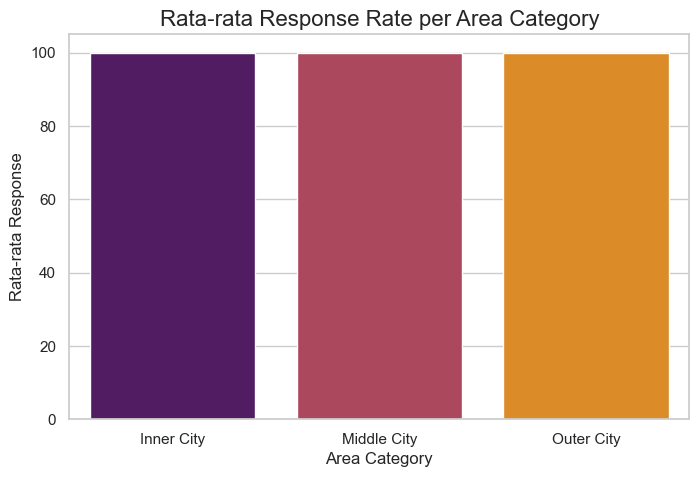

In [811]:
plt.figure(figsize=(8, 5))
sns.barplot(data=response_by_area, x='area_category', y='host_response_rate', palette='inferno')
plt.title('Rata-rata Response Rate per Area Category', fontsize=16)
plt.xlabel('Area Category')
plt.ylabel('Rata-rata Response')
plt.show()

In [812]:
response_by_area

,area_category,host_response_rate
0,Inner City,100.0
1,Middle City,100.0
2,Outer City,100.0


In [813]:
# Data harga per area_category
response_area = [100.0, 100.0, 100.0]
# Rata-rata ulasan per area_category
rating_area = [4.83, 4.78, 4.78]

# Uji korelasi Spearman
correlation, p_value = spearmanr(response_area, rating_area)

print(f"Korelasi Spearman antara respons dan ulasan: {correlation:.5f}")
print(f"P-value: {p_value:.2e}")

if p_value < 0.05:
    print("Tolak hipotesis nol: Ada korelasi signifikan antara harga dan ulasan.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada korelasi signifikan antara harga dan ulasan.")

Korelasi Spearman antara respons dan ulasan: nan
P-value: nan
Gagal menolak hipotesis nol: Tidak ada korelasi signifikan antara harga dan ulasan.


**Interpretasi:**

- Hasil Korelasi Tidak Valid: Korelasi Spearman menghasilkan nilai NaN untuk korelasi dan p-value karena semua nilai dalam variabel host_response_rate sama, yaitu 100.0 untuk semua kategori area. Ketika tidak ada variasi dalam data (nilai konstan), Spearman tidak dapat menghitung hubungan dengan variabel lain.

**Insight:**

- Tidak dapat ditentukan apakah ada hubungan antara tingkat respons host dan ulasan (review_scores_rating) karena data host_response_rate tidak memiliki variasi. Variabel konstan tidak memberikan informasi yang cukup untuk analisis korelasi.

### **Kesimpulan**

**Perbedaan Median Rating Antar Area (Kruskal-Wallis Test)**

Hasil: p-value = 1.24e-05 menunjukkan ada perbedaan signifikan secara statistik antara median rating di Inner City, Middle City, dan Outer City.

Kesimpulan: Inner City memiliki median rating ulasan yang secara signifikan lebih tinggi dibanding Middle City dan Outer City.


**Perbandingan Median Rating antara Middle City dan Outer City (Mann-Whitney U Test)**

Hasil: p-value = 0.1616 menunjukkan tidak ada perbedaan signifikan antara median rating Middle City dan Outer City.

Kesimpulan: Ulasan di Middle City dan Outer City serupa, tetapi keduanya lebih rendah dibanding Inner City.


**Distribusi Jenis Kamar per Area (Chi-Square Test)**

Hasil: p-value = 2.06e-61 menunjukkan adanya perbedaan signifikan dalam distribusi jenis kamar antara Inner City, Middle City, dan Outer City.

Kesimpulan: Inner City memiliki proporsi jenis kamar tertentu, seperti Entire Home/Apartment, yang lebih tinggi, yang dapat memengaruhi ulasan.


**Hubungan Harga dan Rating (Spearman Correlation)**

Hasil: Korelasi = 0.86603, p-value = 0.333 menunjukkan tidak ada hubungan signifikan antara harga dan ulasan.
Kesimpulan: Harga bukan faktor utama yang memengaruhi ulasan tinggi di Inner City.
Hubungan Tingkat Respons Host dan Ulasan (Spearman Correlation)

Hasil: Korelasi tidak valid karena host_response_rate memiliki nilai konstan di semua area.
Kesimpulan: Tidak ada cukup informasi untuk menyimpulkan hubungan tingkat respons host terhadap ulasan.

**Faktor-Faktor yang Mungkin Menyebabkan Inner City Memiliki Rating Tertinggi**

- Banyaknya listing per jenis properti.

### **2. Dampak Pandemi COVID-19 terhadap Perubahan Preferensi Lokasi Tamu**

Penelitian ini bertujuan untuk mengeksplorasi bagaimana pandemi COVID-19 memengaruhi preferensi tamu terhadap lokasi properti Airbnb di Bangkok. Analisis ini akan mengidentifikasi perubahan pola minat tamu selama dan setelah pandemi, serta mengkaji faktor-faktor yang mungkin memengaruhi pergeseran preferensi tersebut.

In [818]:
def get_covid_period(date):
    if date < pd.Timestamp('2020-03-01'):
        return 'Pre-COVID'
    elif date < pd.Timestamp('2022-01-01'):
        return 'During COVID'
    else:
        return 'Recovery Period'

# Menambahkan kolom periode COVID berdasarkan tanggal review
airbnb['covid_period'] = airbnb['last_review'].apply(get_covid_period)
airbnb_precovid=airbnb[(airbnb['covid_period']=='Pre-COVID')&(airbnb['last_review']>'1970-01-01')]
airbnb_covid=airbnb[airbnb['covid_period']=='During COVID']
airbnb_recovery=airbnb[airbnb['covid_period']=='Recovery Period']

Mengecek apakah tiap kategori `covid_period` terhadap `review_scores_rating` memiliki distibusi yang normal atau tidak dengan menggunakan uji normalitas Saphiro Wilk.

In [820]:
data_periods = {
    'Pre-COVID': airbnb_precovid['review_scores_rating'].dropna(),
    'During COVID': airbnb_covid['review_scores_rating'].dropna(),
    'Recovery Period': airbnb_recovery['review_scores_rating'].dropna()
}

for period, data in data_periods.items():
    stat, p_value = shapiro(data)
    print(f"{period} - Statistik Shapiro-Wilk: {stat:.5f}, P-value: {p_value:.5f}")
    if p_value < 0.05:
        print(f"Kesimpulan: Data {period} tidak terdistribusi normal.\n")
    else:
        print(f"Kesimpulan: Data {period} terdistribusi normal.\n")

Pre-COVID - Statistik Shapiro-Wilk: 0.72084, P-value: 0.00000
Kesimpulan: Data Pre-COVID tidak terdistribusi normal.

During COVID - Statistik Shapiro-Wilk: 0.76778, P-value: 0.00000
Kesimpulan: Data During COVID tidak terdistribusi normal.

Recovery Period - Statistik Shapiro-Wilk: 0.68251, P-value: 0.00000
Kesimpulan: Data Recovery Period tidak terdistribusi normal.



Karena uji normalitas pada ketiga periode tidak terdistribusi normal, maka kita akan menggunakan median.

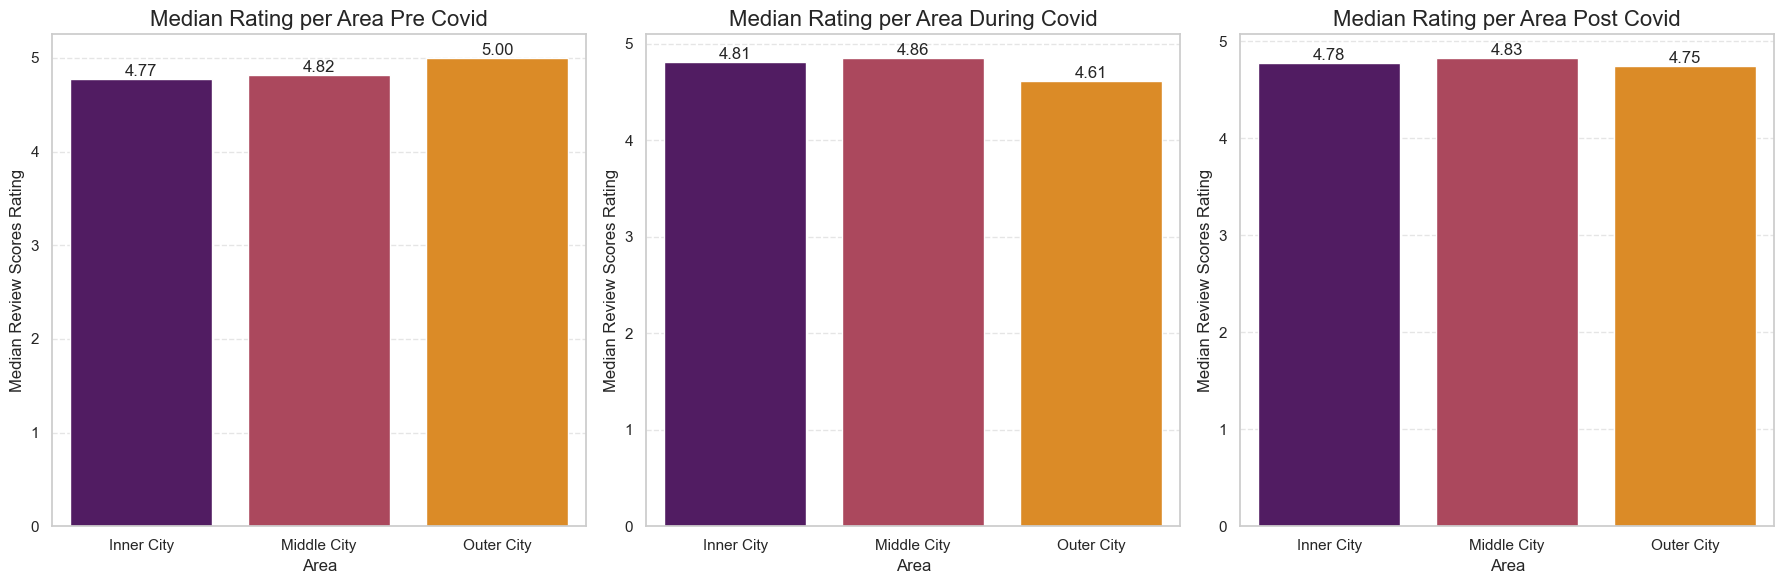

In [822]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

precovid_median = airbnb_precovid.groupby('area_category')['review_scores_rating'].median().reset_index()
covid_median = airbnb_covid.groupby('area_category')['review_scores_rating'].median().reset_index()
recovery_median = airbnb_recovery.groupby('area_category')['review_scores_rating'].median().reset_index()

# Plot Pre-COVID
sns.barplot(data=precovid_median, x='area_category', y='review_scores_rating', palette='inferno', ax=axes[0])
axes[0].set_title('Median Rating per Area Pre Covid', fontsize=16)
axes[0].set_xlabel('Area')
axes[0].set_ylabel('Median Review Scores Rating')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
for bar in axes[0].containers:  # Menambahkan label nilai
    axes[0].bar_label(bar, fmt='%.2f')

# Plot During-COVID
sns.barplot(data=covid_median, x='area_category', y='review_scores_rating', palette='inferno', 
            order=['Inner City', 'Middle City', 'Outer City'], ax=axes[1])
axes[1].set_title('Median Rating per Area During Covid', fontsize=16)
axes[1].set_xlabel('Area')
axes[1].set_ylabel('Median Review Scores Rating')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
for bar in axes[1].containers:  # Menambahkan label nilai
    axes[1].bar_label(bar, fmt='%.2f')

# Plot After-COVID
sns.barplot(data=recovery_median, x='area_category', y='review_scores_rating', palette='inferno', 
            order=['Inner City', 'Middle City', 'Outer City'], ax=axes[2])
axes[2].set_title('Median Rating per Area Post Covid', fontsize=16)
axes[2].set_xlabel('Area')
axes[2].set_ylabel('Median Review Scores Rating')
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
for bar in axes[2].containers:  # Menambahkan label nilai
    axes[2].bar_label(bar, fmt='%.2f')

plt.tight_layout()
plt.show()

In [823]:
precovid_ratings = airbnb_precovid['review_scores_rating'].dropna()
covid_ratings = airbnb_covid['review_scores_rating'].dropna()
recovery_ratings = airbnb_recovery['review_scores_rating'].dropna()

# Uji Kruskal-Wallis
stat, p_value = kruskal(precovid_ratings, covid_ratings, recovery_ratings)

print(f"Statistik Uji Kruskal-Wallis: {stat:.2f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("Tolak hipotesis nol: Ada perbedaan signifikan antara median ulasan pada ketiga periode.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada perbedaan signifikan antara median ulasan pada ketiga periode.")

Statistik Uji Kruskal-Wallis: 16.70
P-value: 0.00024
Tolak hipotesis nol: Ada perbedaan signifikan antara median ulasan pada ketiga periode.


**Interpretasi**

- Hasil uji Kruskal-Wallis (p-value = 0.00024 < 0.05) mengkonfirmasi adanya perbedaan signifikan rating antara ketiga periode

**Insight**

1. Perubahan Pola Rating Antar Periode:
- Pre-Covid: Outer City memiliki rating tertinggi (5.00), diikuti Middle City (4.82) dan Inner City (4.77)
- During Covid: Middle City justru memimpin (4.86), Inner City (4.81), sedangkan Outer City mengalami penurunan signifikan (4.61)
- Post-Covid: Middle City tetap tertinggi (4.83), Inner City (4.78), dan Outer City (4.75)

2. Dampak Signifikan COVID-19:
- Outer City mengalami penurunan rating paling drastis selama COVID-19 (dari 5.00 menjadi 4.61)
- Area Inner dan Middle City lebih stabil dalam mempertahankan rating selama pandemi

**Pertanyaan untuk Analisis Lebih Lanjut:**
- Mengapa Outer City mengalami penurunan rating paling drastis selama COVID-19?
- Mengapa Middle City konsisten mempertahankan rating tinggi di semua periode?
- Mengapa Inner City stabil dengan variasi rating yang relatif kecil?

In [825]:
# Distribusi room_type per area_category
room_type_dist_area_precovid = airbnb_precovid.groupby(['area_category', 'room_type']).size().unstack(fill_value=0)
room_type_dist_area_covid = airbnb_covid.groupby(['area_category', 'room_type']).size().unstack(fill_value=0)
room_type_dist_area_recovery = airbnb_recovery.groupby(['area_category', 'room_type']).size().unstack(fill_value=0)

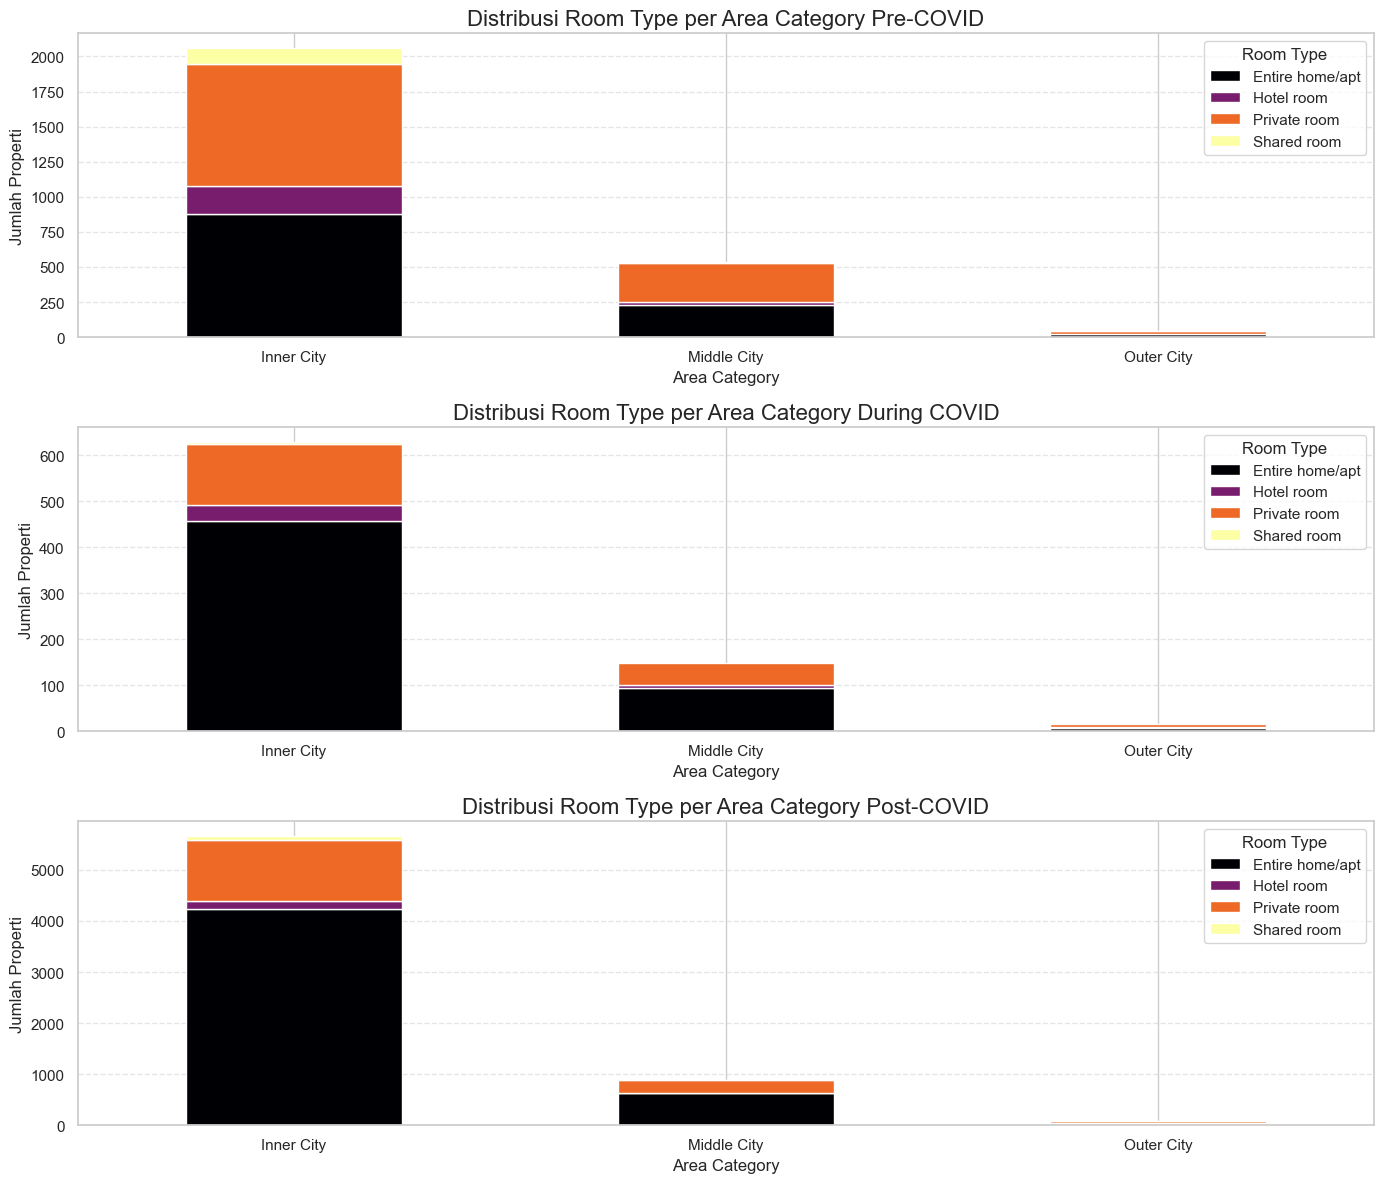

In [826]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot untuk room_type_dist_area_precovid
room_type_dist_area_precovid.plot(kind='bar', stacked=True, ax=axes[0], colormap='inferno')
axes[0].set_title('Distribusi Room Type per Area Category Pre-COVID', fontsize=16)
axes[0].set_xlabel('Area Category')
axes[0].set_ylabel('Jumlah Properti')
axes[0].legend(title='Room Type')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].tick_params(axis='x', rotation=0)

# Plot untuk room_type_dist_area_covid
room_type_dist_area_covid.plot(kind='bar', stacked=True, ax=axes[1], colormap='inferno')
axes[1].set_title('Distribusi Room Type per Area Category During COVID', fontsize=16)
axes[1].set_xlabel('Area Category')
axes[1].set_ylabel('Jumlah Properti')
axes[1].legend(title='Room Type')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=0)

# Plot untuk room_type_dist_area_recovery
room_type_dist_area_recovery.plot(kind='bar', stacked=True, ax=axes[2], colormap='inferno')
axes[2].set_title('Distribusi Room Type per Area Category Post-COVID', fontsize=16)
axes[2].set_xlabel('Area Category')
axes[2].set_ylabel('Jumlah Properti')
axes[2].legend(title='Room Type')
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [827]:
print('\t\tPersebaran Roomtype Periode Pre COVID-19')
print(room_type_dist_area_precovid)
print('\t\tPersebaran Roomtype Periode During COVID-19')
print(room_type_dist_area_covid)
print('\t\tPersebaran Roomtype Periode Post COVID-19')
print(room_type_dist_area_recovery)

		Persebaran Roomtype Periode Pre COVID-19
room_type      Entire home/apt  Hotel room  Private room  Shared room
area_category                                                        
Inner City                 879         199           870          113
Middle City                231          17           281            6
Outer City                  20           0            21            6
		Persebaran Roomtype Periode During COVID-19
room_type      Entire home/apt  Hotel room  Private room  Shared room
area_category                                                        
Inner City                 457          34           133            5
Middle City                 94           7            47            0
Outer City                   7           1             8            0
		Persebaran Roomtype Periode Post COVID-19
room_type      Entire home/apt  Hotel room  Private room  Shared room
area_category                                                        
Inner City                4

**Insight**
  
1. **Mengapa Outer City mengalami penurunan rating paling drastis (5.00 → 4.61)?**
- Pre-COVID: 47 properti total (20 entire home, 21 private room, 6 shared)
- During COVID: Turun drastis jadi hanya 16 properti (7 entire home, 8 private room)
- Jumlah yang sangat sedikit ini membuat rating sangat sensitif - setiap review buruk akan berdampak besar pada rata-rata

2. **Mengapa Middle City konsisten rating tinggi?**
- Memiliki jumlah properti "menengah" - tidak terlalu banyak seperti Inner City tapi cukup signifikan
- Pre-COVID: 535 properti → During: 148 properti → Post: 889 properti
- Jumlah ini cukup untuk memberikan pilihan bagi tamu, tapi tidak terlalu banyak yang bisa menurunkan standar kualitas
- Proporsi entire home/apt meningkat signifikan post-COVID (627 dari 889 total), sesuai preferensi pasar

3. **Mengapa Inner City stabil dengan variasi rating kecil?**
- Volume properti sangat besar: Pre: 2061 → During: 629 → Post: 5666
- Jumlah besar ini membuat rating lebih stabil karena:
  * Lebih banyak review = rating lebih terdistribusi
  * Banyak pilihan bagi tamu = bisa memilih sesuai preferensi
  * Review buruk individual memiliki dampak lebih kecil pada rata-rata
- Adaptasi cepat post-COVID dengan dominasi entire home/apt (4229 dari 5666)

In [829]:
data_periods = {
    'Pre-COVID': airbnb_precovid['price'],
    'During COVID': airbnb_covid['price'],
    'Recovery Period': airbnb_recovery['price']
}

for period, data in data_periods.items():
    stat, p_value = shapiro(data)
    print(f"{period} - Statistik Shapiro-Wilk: {stat:.5f}, P-value: {p_value:.5f}")
    if p_value < 0.05:
        print(f"Kesimpulan: Data {period} tidak terdistribusi normal.\n")
    else:
        print(f"Kesimpulan: Data {period} terdistribusi normal.\n")

Pre-COVID - Statistik Shapiro-Wilk: 0.05532, P-value: 0.00000
Kesimpulan: Data Pre-COVID tidak terdistribusi normal.

During COVID - Statistik Shapiro-Wilk: 0.06041, P-value: 0.00000
Kesimpulan: Data During COVID tidak terdistribusi normal.

Recovery Period - Statistik Shapiro-Wilk: 0.03352, P-value: 0.00000
Kesimpulan: Data Recovery Period tidak terdistribusi normal.



In [830]:
# Rata-rata harga per area_category
price_area_precovid = round(airbnb_precovid.groupby('area_category')['price'].median().reset_index())
price_area_covid = round(airbnb_covid.groupby('area_category')['price'].median().reset_index())
price_area_recovery = round(airbnb_recovery.groupby('area_category')['price'].median().reset_index())

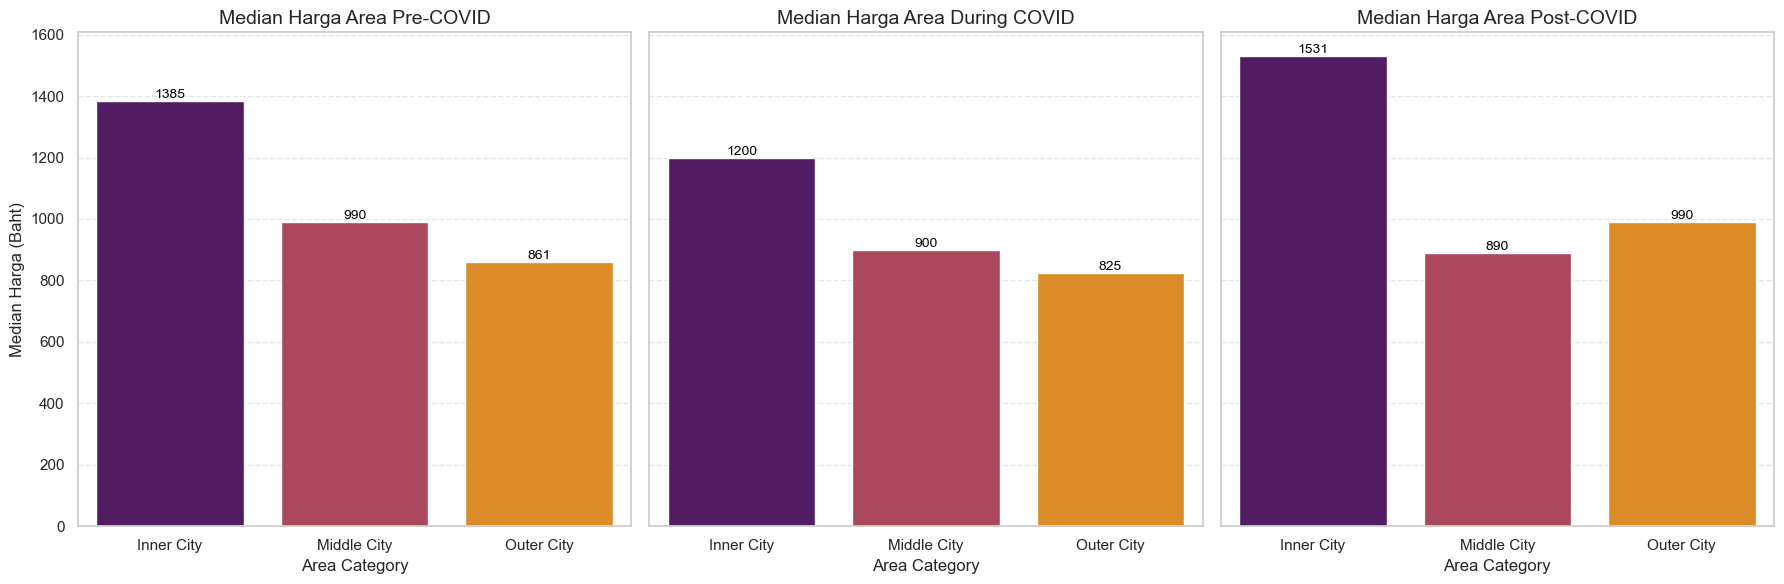

In [831]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Fungsi untuk menambahkan label data di atas setiap batang
def add_labels(ax):
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',  # Label angka tanpa desimal
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=10, color='black'
        )

# Pre-COVID
sns.barplot(x='area_category', y='price', data=price_area_precovid, palette='inferno', ax=axes[0])
axes[0].set_title('Median Harga Area Pre-COVID', fontsize=14)
axes[0].set_xlabel('Area Category')
axes[0].set_ylabel('Median Harga (Baht)')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[0])

# During-COVID
sns.barplot(x='area_category', y='price', data=price_area_covid, palette='inferno', ax=axes[1])
axes[1].set_title('Median Harga Area During COVID', fontsize=14)
axes[1].set_xlabel('Area Category')
axes[1].set_ylabel('Median Harga (Baht)')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[1])

# Post-COVID
sns.barplot(x='area_category', y='price', data=price_area_recovery, palette='inferno', ax=axes[2])
axes[2].set_title('Median Harga Area Post-COVID', fontsize=14)
axes[2].set_xlabel('Area Category')
axes[2].set_ylabel('Median Harga (Baht)')
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[2])

plt.tight_layout()
plt.show()

In [832]:
print('Rata-rata Harga Area Periode Pre COVID-19')
print(price_area_precovid)
print('Rata-rata Harga Area During COVID-19')
print(price_area_covid)
print('Rata-rata Harga Area Periode Post COVID-19')
print(price_area_recovery)

Rata-rata Harga Area Periode Pre COVID-19
  area_category   price
0    Inner City  1385.0
1   Middle City   990.0
2    Outer City   861.0
Rata-rata Harga Area During COVID-19
  area_category   price
0    Inner City  1200.0
1   Middle City   900.0
2    Outer City   825.0
Rata-rata Harga Area Periode Post COVID-19
  area_category   price
0    Inner City  1531.0
1   Middle City   890.0
2    Outer City   990.0


**Insight**

1. **Mengapa Outer City mengalami penurunan rating paling drastis (5.00 → 4.61)?**
- Harga Pre-COVID: 861K → During: 825K → Post: 990K
- Properti sedikit (47 → 16 → 73)
- Kenaikan harga signifikan post-COVID (+165K) dengan jumlah properti terbatas
- Ketidakseimbangan supply-demand: Harga naik tapi pilihan terbatas = ekspektasi tinggi tapi opsi terbatas = rating turun

2. **Mengapa Middle City konsisten rating tinggi?**
- Harga paling stabil: 990K → 900K → 890K
- Jumlah properti moderat (535 → 148 → 889)
- Harga relatif stabil dengan penyesuaian wajar selama pandemi
- Value for money konsisten = ekspektasi tamu terpenuhi = rating stabil tinggi

3. **Mengapa Inner City stabil dengan variasi rating kecil?**
- Harga tertinggi & fluktuatif: 1385K → 1200K → 1531K
- Volume properti besar (2061 → 629 → 5666)
- Meski harga tinggi, banyaknya pilihan memungkinkan tamu memilih sesuai budget
- Kenaikan harga post-COVID (+331K) diimbangi peningkatan supply drastis (5666 properti)

In [834]:
response_by_area_precovid= round(airbnb_precovid.groupby('area_category')['host_response_rate'].mean().reset_index(),2)
response_by_area_covid= round(airbnb_covid.groupby('area_category')['host_response_rate'].mean().reset_index(),2)
response_by_area_recovery= round(airbnb_recovery.groupby('area_category')['host_response_rate'].mean().reset_index(),2)

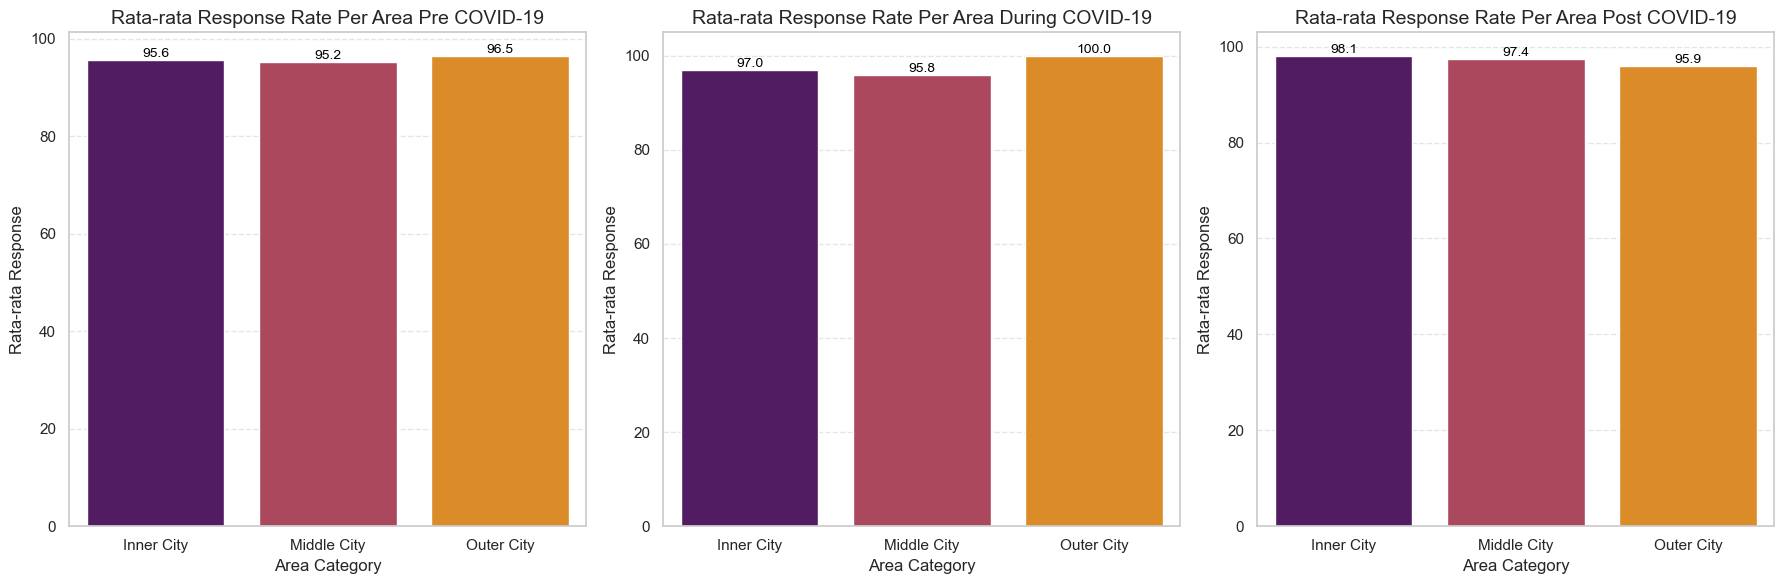

In [835]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Fungsi untuk menambahkan label data
def add_labels(ax):
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}',  # Label angka dengan 1 desimal
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=10, color='black'
        )

# Pre-COVID Response Rate
sns.barplot(data=response_by_area_precovid, x='area_category', y='host_response_rate', palette='inferno', ax=axes[0])
axes[0].set_title('Rata-rata Response Rate Per Area Pre COVID-19', fontsize=14)
axes[0].set_xlabel('Area Category')
axes[0].set_ylabel('Rata-rata Response')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[0])  # Tambahkan label data

# During-COVID Response Rate
sns.barplot(data=response_by_area_covid, x='area_category', y='host_response_rate', palette='inferno', ax=axes[1])
axes[1].set_title('Rata-rata Response Rate Per Area During COVID-19', fontsize=14)
axes[1].set_xlabel('Area Category')
axes[1].set_ylabel('Rata-rata Response')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[1])  # Tambahkan label data

# Post-COVID Response Rate
sns.barplot(data=response_by_area_recovery, x='area_category', y='host_response_rate', palette='inferno', ax=axes[2])
axes[2].set_title('Rata-rata Response Rate Per Area Post COVID-19', fontsize=14)
axes[2].set_xlabel('Area Category')
axes[2].set_ylabel('Rata-rata Response')
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
add_labels(axes[2])  # Tambahkan label data

plt.tight_layout()
plt.show()


In [836]:
print('Response Rate Rata-rata Area Periode Pre COVID-19')
print(response_by_area_precovid)
print('Response Rate Rata-rata Area During COVID-19')
print(response_by_area_covid)
print('Response Rate Rata-rata Area Post COVID-19')
print(response_by_area_recovery)

Response Rate Rata-rata Area Periode Pre COVID-19
  area_category  host_response_rate
0    Inner City               95.61
1   Middle City               95.18
2    Outer City               96.51
Response Rate Rata-rata Area During COVID-19
  area_category  host_response_rate
0    Inner City               97.01
1   Middle City               95.85
2    Outer City              100.00
Response Rate Rata-rata Area Post COVID-19
  area_category  host_response_rate
0    Inner City               98.07
1   Middle City               97.36
2    Outer City               95.86


**Insight**

1. **Outer City - Penurunan rating drastis selama COVID (5.00 → 4.61):**
- Response rate naik ke 100% during COVID tapi turun ke 95.86% post-COVID
- Jumlah properti sangat sedikit (47 → 16 → 73)
- Harga naik signifikan (861K → 825K → 990K)
- Response rate 100% during COVID menunjukkan host sangat aktif, tapi kombinasi kenaikan harga + pilihan terbatas + turunnya response rate post-COVID membuat ekspektasi tamu tidak terpenuhi

2. **Middle City - Rating konsisten tinggi:**
- Response rate stabil (95.18% → 95.85% → 97.36%)
- Harga paling stabil (990K → 900K → 890K)
- Jumlah properti moderat (535 → 148 → 889)
- Konsistensi response rate + harga stabil mencerminkan kualitas layanan yang konsisten = rating tinggi berkelanjutan

3. **Inner City - Rating stabil dengan variasi kecil:**
- Response rate terus meningkat (95.61% → 97.01% → 98.07%)
- Volume properti besar (2061 → 629 → 5666)
- Harga tertinggi & fluktuatif (1385K → 1200K → 1531K)
- Peningkatan response rate menunjukkan perbaikan layanan, membantu menstabilkan rating meski harga tinggi

### **Kesimpulan**

**Perbedaan Rating Signifikan antara Periode:**

Hasil uji Kruskal-Wallis menunjukkan adanya perbedaan signifikan dalam rating antara ketiga periode (Pre-COVID, During COVID, dan Post-COVID).

**Dampak Pandemi COVID-19:**

Outer City: Mengalami penurunan rating paling drastis selama pandemi, mungkin karena jumlah properti yang terbatas dan ketidakseimbangan harga dan pilihan.
Middle City: Menunjukkan ketahanan dengan mempertahankan rating tinggi di semua periode, didukung oleh jumlah properti yang stabil dan harga yang wajar.
Inner City: Meskipun mengalami fluktuasi harga, volume properti yang besar membantu menjaga stabilitas rating.

### **Rekomendasi**

**Inner City**
- Manajemen Harga: Evaluasi kenaikan harga post-COVID (1531K) yang cukup tinggi dan manfaatkan volume properti besar untuk menawarkan variasi harga
- Optimalisasi Supply: Monitor kualitas mengingat volume besar (5666 properti)
- Manfaatkan data response rate yang baik (98.07%) untuk pemasaran

**Middle City**
- Pertahankan Strategi Harga: Lanjutkan pendekatan harga yang stabil (990K → 900K → 890K)sebagai keunggulan kompetitif
- Pengembangan Properti: Jaga keseimbangan supply-demand yang sudah baik
- Pertahankan standar layanan yang menghasilkan rating konsisten tinggi

**Outer City**
- Penyesuaian Harga: Evaluasi ulang kenaikan harga post-COVID (990K) dengan keterbatasan pilihan properti
- Pengembangan Area: Tingkatkan jumlah properti secara signifikan
- Perbaiki response rate yang menurun (95.86%)

### **3. Perubahan Pola Musiman**

Penelitian ini bertujuan untuk mengeksplorasi pola musiman dalam industri properti Airbnb di Bangkok, dengan fokus pada perubahan yang terjadi sebelum dan setelah pandemi COVID-19. Analisis ini akan melihat bagaimana perubahan musiman mempengaruhi permintaan dan penawaran properti, serta bagaimana host dapat mengoptimalkan strategi pemasaran dan penetapan harga berdasarkan pola musiman tersebut.

In [841]:
airbnb_precovid=airbnb[(airbnb['covid_period']=='Pre-COVID')&(airbnb['last_review']>'1970-01-01')]
airbnb_covid=airbnb[airbnb['covid_period']=='During COVID']
airbnb_recovery=airbnb[airbnb['covid_period']=='Recovery Period']

# Mengelompokkan data berdasarkan bulan dan periode COVID
airbnb_precovid['month'] = pd.to_datetime(airbnb_precovid['last_review']).dt.month
airbnb_covid['month'] = pd.to_datetime(airbnb_covid['last_review']).dt.month
airbnb_recovery['month'] = pd.to_datetime(airbnb_recovery['last_review']).dt.month

In [842]:
# Menghitung median harga bulanan untuk setiap periode
price_precovid = airbnb_precovid.groupby('month')['price'].median().reset_index()
price_covid = airbnb_covid.groupby('month')['price'].median().reset_index()
price_recovery = airbnb_recovery.groupby('month')['price'].median().reset_index()

# Menambahkan kolom periode
price_precovid['period'] = 'Pre-COVID'
price_covid['period'] = 'During COVID'
price_recovery['period'] = 'Post-COVID'

price_seasonal = pd.concat([price_precovid, price_covid, price_recovery])

# Fungsi untuk mencari peak dan low season untuk setiap periode
def get_price_peak_low_season(price_data, period_name):
    peak = price_data.loc[price_data['price'].idxmax()]
    low = price_data.loc[price_data['price'].idxmin()]
    return f"{period_name} - Peak Season: Bulan {peak['month']} - Harga: {peak['price']}, Low Season: Bulan {low['month']} - Harga: {low['price']}"

print(get_price_peak_low_season(price_precovid, 'Pre-COVID'))
print(get_price_peak_low_season(price_covid, 'During COVID'))
print(get_price_peak_low_season(price_recovery, 'Post-COVID'))

Pre-COVID - Peak Season: Bulan 4 - Harga: 1530.0, Low Season: Bulan 8 - Harga: 1199.5
During COVID - Peak Season: Bulan 1 - Harga: 2680.0, Low Season: Bulan 4 - Harga: 1000.0
Post-COVID - Peak Season: Bulan 12 - Harga: 1557.0, Low Season: Bulan 1 - Harga: 1190.0


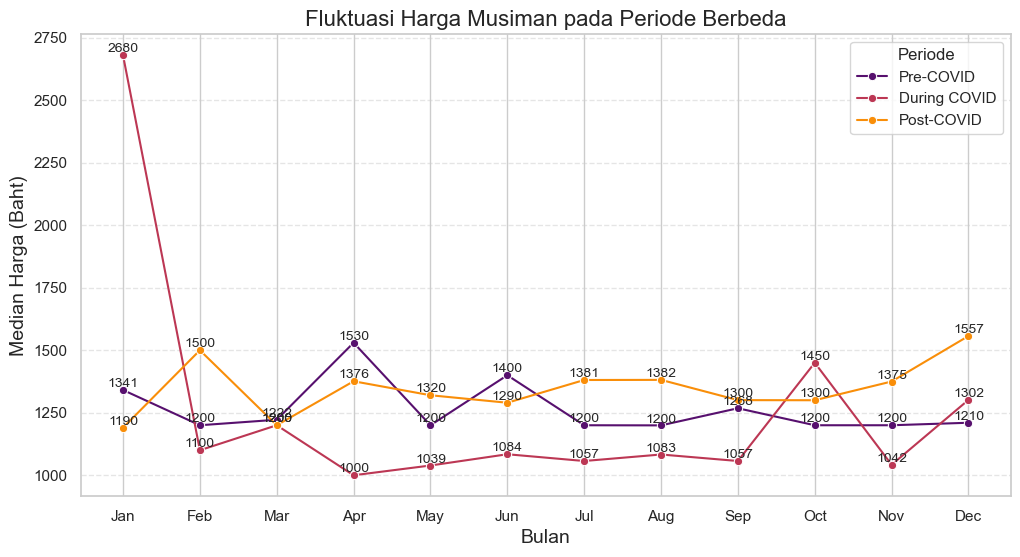

In [843]:
plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=price_seasonal, x='month', y='price', hue='period', marker='o', palette='inferno')

# Tambahkan label data pada setiap titik
for period in price_seasonal['period'].unique():
    subset = price_seasonal[price_seasonal['period'] == period]
    for x, y in zip(subset['month'], subset['price']):
        plt.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=10)

plt.title('Fluktuasi Harga Musiman pada Periode Berbeda', fontsize=16)
plt.xlabel('Bulan', fontsize=14)
plt.ylabel('Median Harga (Baht)', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Periode')
plt.show()

**Insight**

1. Pola Peak Season:
- Pre-COVID: Peak season di pertengahan tahun (April)
- During COVID: Peak season bergeser ke awal tahun (Januari)
- Post-COVID: Peak season bergeser ke akhir tahun (Desember)

4. Tren Musiman:
- Akhir tahun (Desember) menunjukkan tren kenaikan, terutama post-COVID

In [946]:
# Mengelompokkan data berdasarkan bulan dan periode COVID, kemudian menghitung jumlah last_review per bulan
reviews_precovid_last = airbnb_precovid.groupby('month')['last_review'].count().reset_index()
reviews_covid_last = airbnb_covid.groupby('month')['last_review'].count().reset_index()
reviews_recovery_last = airbnb_recovery.groupby('month')['last_review'].count().reset_index()

reviews_precovid_last['period'] = 'Pre-COVID'
reviews_covid_last['period'] = 'During COVID'
reviews_recovery_last['period'] = 'Post-COVID'

reviews_last_seasonal = pd.concat([reviews_precovid_last, reviews_covid_last, reviews_recovery_last])

reviews_last_seasonal_median = reviews_last_seasonal.groupby(['period', 'month'])['last_review'].median().reset_index()

In [948]:
reviews_last_seasonal_median

,period,month,last_review
0,During COVID,1,11.0
1,During COVID,2,15.0
2,During COVID,3,360.0
3,During COVID,4,70.0
4,During COVID,5,44.0
5,During COVID,6,38.0
6,During COVID,7,43.0
7,During COVID,8,48.0
8,During COVID,9,44.0
9,During COVID,10,33.0


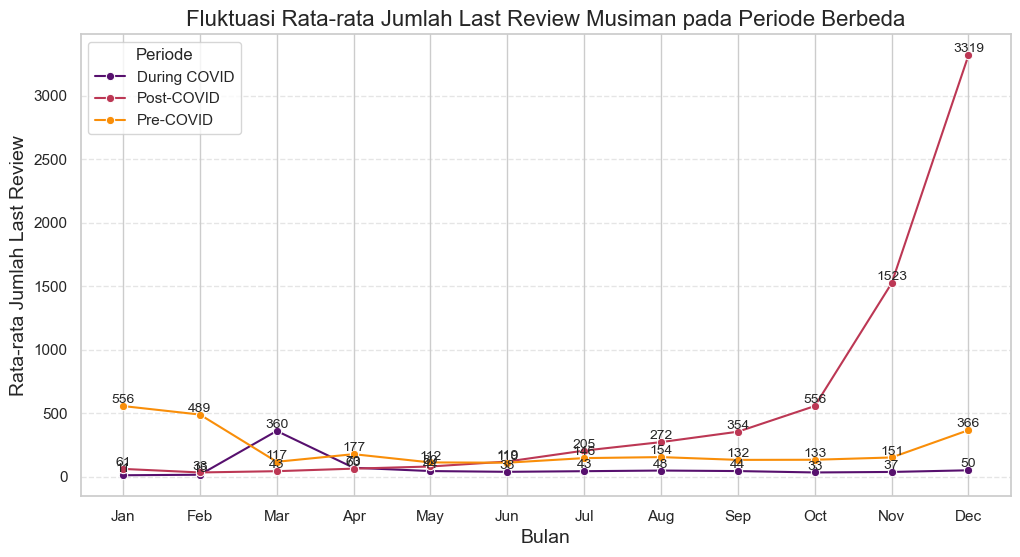

In [912]:
plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=reviews_last_seasonal_median, x='month', y='last_review', hue='period', marker='o', palette='inferno')

# Menambahkan label data pada setiap titik
for period in reviews_last_seasonal_median['period'].unique():
    subset = reviews_last_seasonal_median[reviews_last_seasonal_median['period'] == period]
    for x, y in zip(subset['month'], subset['last_review']):
        plt.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=10)

plt.title('Fluktuasi Rata-rata Jumlah Last Review Musiman pada Periode Berbeda', fontsize=16)
plt.xlabel('Bulan', fontsize=14)
plt.ylabel('Rata-rata Jumlah Last Review', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Periode')
plt.show()

**Insight**

1. Pola Peak Season:
- Pre-COVID: Peak season di awal tahun (Januari)
- During COVID: Peak season bergeser ke awal tahun (Maret)
- Post-COVID: Peak season bergeser ke akhir tahun (Desember)

4. Tren Musiman:
- Akhir tahun ke awal tahun (Desember-Januari) menunjukkan tren kenaikan, terutama post-COVID
- Peningkatan yang signifikan dari pertengahan tahun ke akhir tahun yang konsisten pada periode post-COVID

### **Kesimpulan**

1. **Dampak COVID terhadap Harga dan Aktivitas:**
- Periode During COVID menunjukkan lonjakan harga ekstrem di Januari (2680) diikuti penurunan drastis, sementara jumlah review justru sangat rendah dan stabil
- Harga cenderung lebih rendah selama pandemi dibanding periode lainnya

2. **Pemulihan Post-COVID:**
- Terjadi pemulihan yang signifikan dengan harga yang stabil dan cenderung meningkat, bahkan melampaui level Pre-COVID
- Jumlah review melonjak drastis di akhir tahun (mencapai 3319 review di Desember), menunjukkan peningkatan aktivitas konsumen yang luar biasa

3. **Perubahan Pola Perilaku:**
- Pre-COVID: Harga dan review relatif stabil dan terdistribusi merata sepanjang tahun
- Post-COVID: Terjadi pergeseran dimana aktivitas review terkonsentrasi di akhir tahun, bersamaan dengan tren kenaikan harga
- Menunjukkan perubahan fundamental dalam perilaku konsumen dan dinamika pasar setelah pandemi

Secara keseluruhan, data menunjukkan bahwa pasar telah pulih dari dampak COVID-19 dengan pola baru, ditandai dengan peningkatan aktivitas konsumen dan stabilitas harga yang lebih tinggi, terutama di akhir tahun.

### **Rekomendasi**

1. **Strategi Harga dan Inventory**
- Lakukan penyesuaian strategi harga yang lebih agresif untuk periode akhir tahun (November-Desember) mengikuti tren peningkatan permintaan
- Persiapkan stok yang lebih besar untuk mengantisipasi lonjakan permintaan di akhir tahun
- Pertahankan harga yang kompetitif di periode low season untuk menjaga stabilitas penjualan

2. **Optimalisasi Layanan Pelanggan**
- Tingkatkan kapasitas layanan pelanggan terutama di periode peak season (akhir tahun) untuk menangani peningkatan aktivitas review
- Implementasikan sistem otomatis untuk manajemen review dan feedback pelanggan
- Berikan insentif khusus untuk mendorong review positif di periode low season